In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.optimize import least_squares

# Data Preparation

In [2]:
#Load swaption data
swaption_df = pd.read_excel('IR Data.xlsx', sheet_name='Swaption', skiprows=2)
swaption_df_pivoted = swaption_df.melt(id_vars=["Expiry", "Tenor"], var_name="delta", value_name="impliedVol")

In [3]:
#Load par swap rate from part 1
par_swap_rate_df = pd.read_csv("par_swap_rate.csv")
par_swap_rate_df = par_swap_rate_df.rename(columns={"Unnamed: 0": "Expiry"})
par_swap_rate_df_pivoted = par_swap_rate_df.melt(id_vars="Expiry", var_name="Tenor", value_name="parSwap")

In [29]:
#Load discount factors from part 1
discount_factors_df = pd.read_csv("discount_factors.csv")
discount_factors_df = discount_factors_df[["Tenor", "OIS Discount Factor", "LIBOR Discount Factor"]].copy()

In [5]:
#Combining tables
data_df = swaption_df_pivoted.merge(par_swap_rate_df_pivoted, on = ["Expiry", "Tenor"], how = "left")

In [6]:
def generate_swap_delta(x):
    if x == "ATM":
        delta = 0
    else:
        delta = int(x.split("bps")[0]) * 0.0001
    return delta

In [7]:
data_df["impliedVol"] = data_df["impliedVol"] / 100
data_df["swapDelta"] = data_df["delta"].apply(lambda x: generate_swap_delta(x))
data_df["strike"] = data_df["parSwap"] + data_df["swapDelta"]
data_df["Expiry_no"] = data_df["Expiry"].apply(lambda x: int(x.split("Y")[0]))
data_df["Tenor_no"] = data_df["Tenor"].apply(lambda x: int(x.split("Y")[0]))

In [8]:
data_df

,Expiry,Tenor,delta,impliedVol,parSwap,swapDelta,strike,Expiry_no,Tenor_no
0,1Y,1Y,-200bps,0.9157,0.032007,-0.02,0.012007,1,1
1,1Y,2Y,-200bps,0.8327,0.033259,-0.02,0.013259,1,2
2,1Y,3Y,-200bps,0.7392,0.034011,-0.02,0.014011,1,3
3,1Y,5Y,-200bps,0.5519,0.035255,-0.02,0.015255,1,5
4,1Y,10Y,-200bps,0.4118,0.038428,-0.02,0.018428,1,10
...,...,...,...,...,...,...,...,...,...
160,10Y,1Y,+200bps,0.2578,0.042189,0.02,0.062189,10,1
161,10Y,2Y,+200bps,0.2571,0.043116,0.02,0.063116,10,2
162,10Y,3Y,+200bps,0.2537,0.044097,0.02,0.064097,10,3
163,10Y,5Y,+200bps,0.2280,0.046249,0.02,0.066249,10,5


In [9]:
tenor_list = data_df['Tenor'].unique().tolist()
expiry_list = data_df['Expiry'].unique().tolist()

# Displaced Diffusion Calibration

In [95]:
def Black76Call(F,K,PVBP,sigma,T):
    d1 = (np.log(F/K) + 0.5*(sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return PVBP * (F*norm.cdf(d1) - K*norm.cdf(d2))

def Black76Put(F,K,PVBP,sigma,T):
    d1 = (np.log(F/K) + 0.5*(sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return PVBP * (K*norm.cdf(-d2) - F*norm.cdf(-d1))


def DisplacedDiffusionCall(F, K, PVBP, sigma, T, beta):
    return Black76Call(F = F/beta, 
                       K = (K + ((1-beta)/beta)*F),
                       PVBP = PVBP,
                       sigma = sigma*beta,
                       T = T)

def DisplacedDiffusionPut(F, K, PVBP, sigma, T, beta):
    return Black76Put(F = F/beta, 
                       K = (K + ((1-beta)/beta)*F),
                       PVBP = PVBP,
                       sigma = sigma*beta,
                       T = T)
                   
                   
def DisplacedDiffusion(F,K,PVBP,sigma,T,beta):
    if F <= K:
        price =  DisplacedDiffusionCall(F, K, PVBP, sigma, T, beta) #payoff of a payer swaption
    elif F > K:
        price =  DisplacedDiffusionPut(F, K, PVBP, sigma, T, beta) #payoff of a receiver swaption
    return price

def ImpVol(F, K, PVBP, T, sigma, beta):
    if F <= K:
        price = DisplacedDiffusionCall(F,K,PVBP,sigma, T, beta)
        iv = brentq(lambda sigma: price - Black76Call(F, K, PVBP, sigma, T),
                                 1e-12,10)
        
    elif F > K:
        price = DisplacedDiffusionPut(F,K,PVBP,sigma,T,beta)
        iv = brentq(lambda sigma: price - Black76Put(F, K, PVBP, sigma, T),
                                 1e-12,10)
    return iv 

def ddcalibration(x,sigma,strikes,vols,F,T,PVBP):
    error=0.0
    for i,vol in enumerate(vols):
        error += (vol - ImpVol(F,strikes[i],PVBP,T,sigma,x))**2
    return error


In [11]:
#Interpolation of OIS Discount Factors
def OISDifInterp(tenor):
    xp = list(discount_factors_df['Tenor'])
    yp = list(discount_factors_df['OIS Discount Factor'])
    return np.interp(tenor, xp, yp)

#PVBP Formula
def PVBP_calculation(expiry,tenor):
    m = int(tenor/0.5)
    summa = 0
    for i in range(1,m+1):
        summa += OISDifInterp(expiry + i*0.5)
    return summa*0.5

In [12]:
#DD model calibration
initialGuess = [0.2]

displaced_diffusion_results = []

for expiry in expiry_list:
    for tenor in tenor_list:
        calibrate_df = data_df[(data_df['Expiry'] == expiry) & (data_df['Tenor'] == tenor)].copy()
        expiry_T = calibrate_df['Expiry_no'].iloc[0]
        tenor_T = calibrate_df['Tenor_no'].iloc[0]
        F = calibrate_df['parSwap'].iloc[0]
        atm_impVol = calibrate_df[calibrate_df["delta"] == "ATM"]['impliedVol'].iloc[0]

        PVBP = PVBP_calculation(expiry_T, tenor_T)
        
        res_dd = least_squares(lambda x: ddcalibration(x, 
                                                        atm_impVol,
                                                        calibrate_df['strike'].values, 
                                                        calibrate_df['impliedVol'].values, 
                                                        F, 
                                                        expiry_T,
                                                        PVBP), 
                                initialGuess,
                                bounds=([0,1])
                                )
        beta = res_dd.x[0]
        sigma = atm_impVol

        dd_temp = [expiry, tenor, beta, sigma]
        displaced_diffusion_results.append(dd_temp)


In [13]:
#Generate displaced diffusion calibration results dataframe
displaced_diffusion_results_df = pd.DataFrame(displaced_diffusion_results)
displaced_diffusion_results_df.columns = ["Expiry", "Tenor", "Beta", "Sigma"]

In [14]:
displaced_diffusion_results_df

,Expiry,Tenor,Beta,Sigma
0,1Y,1Y,2.843595e-07,0.2250
1,1Y,2Y,7.768592e-08,0.2872
2,1Y,3Y,1.910341e-07,0.2978
3,1Y,5Y,6.677849e-07,0.2607
4,1Y,10Y,1.468493e-07,0.2447
5,5Y,1Y,2.161628e-07,0.2726
6,5Y,2Y,3.172464e-10,0.2983
7,5Y,3Y,2.361346e-08,0.2998
8,5Y,5Y,3.382992e-06,0.2660
9,5Y,10Y,5.029256e-02,0.2451


In [15]:
#Generate calibrated Beta parameters table
beta_df = displaced_diffusion_results_df[["Expiry","Tenor", "Beta"]].copy()
beta_df["Tenor"] = beta_df["Tenor"].apply(lambda x: int(x.split("Y")[0]))

original_expiry_order = beta_df["Expiry"].unique()
original_tenor_order = beta_df["Tenor"].unique()
beta_df.pivot(index="Expiry", columns="Tenor").reindex(index = original_expiry_order)

Beta                                                        
Tenor             1             2             3             5             10
Expiry                                                                      
1Y      2.843595e-07  7.768592e-08  1.910341e-07  6.677849e-07  1.468493e-07
5Y      2.161628e-07  3.172464e-10  2.361346e-08  3.382992e-06  5.029256e-02
10Y     9.040181e-10  9.920316e-08  1.976681e-06  2.429010e-05  4.438203e-03

In [16]:
#Generate calibrated Sigma parameters table
sigma_df = displaced_diffusion_results_df[["Expiry","Tenor", "Sigma"]].copy()
sigma_df["Tenor"] = sigma_df["Tenor"].apply(lambda x: int(x.split("Y")[0]))

original_expiry_order = sigma_df["Expiry"].unique()
original_tenor_order = sigma_df["Tenor"].unique()
sigma_df.pivot(index="Expiry", columns="Tenor").reindex(index = original_expiry_order)

Sigma                                
Tenor       1       2       3       5       10
Expiry                                        
1Y      0.2250  0.2872  0.2978  0.2607  0.2447
5Y      0.2726  0.2983  0.2998  0.2660  0.2451
10Y     0.2854  0.2928  0.2940  0.2674  0.2437

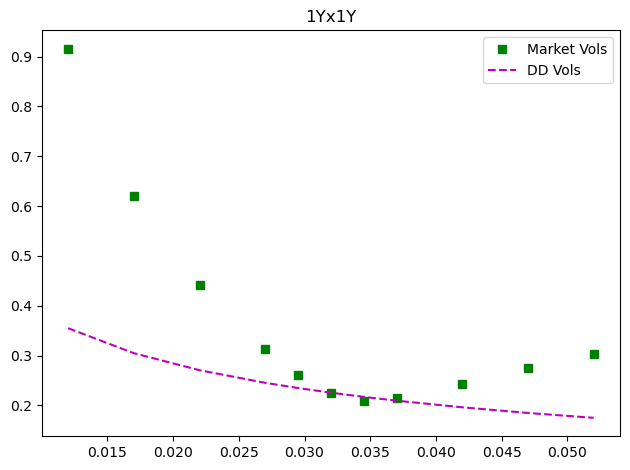

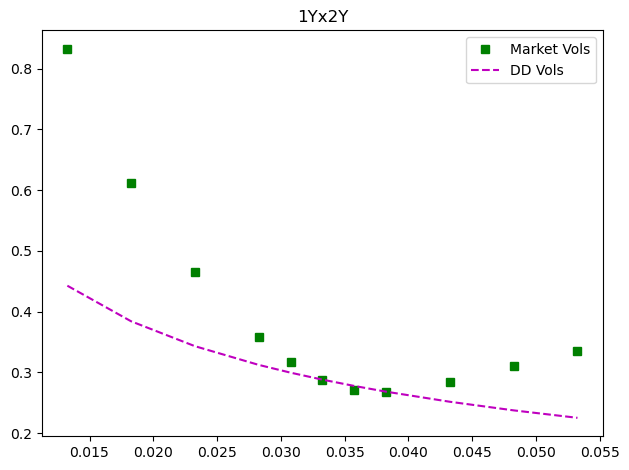

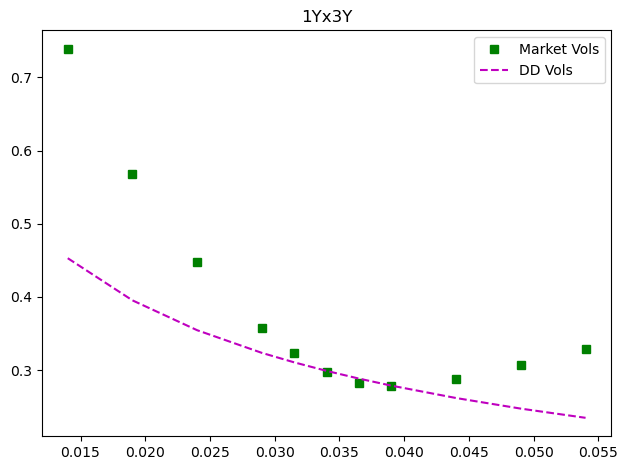

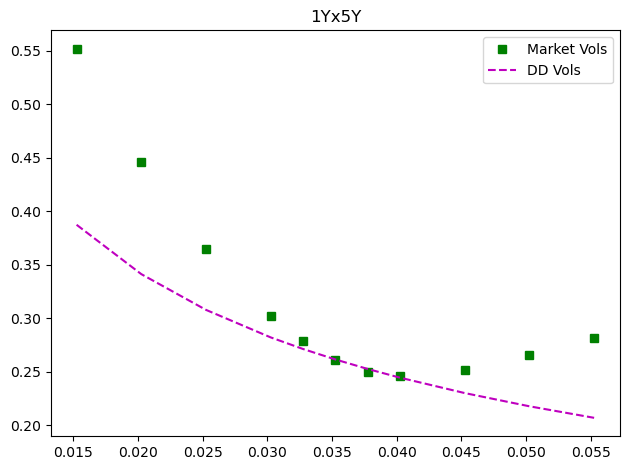

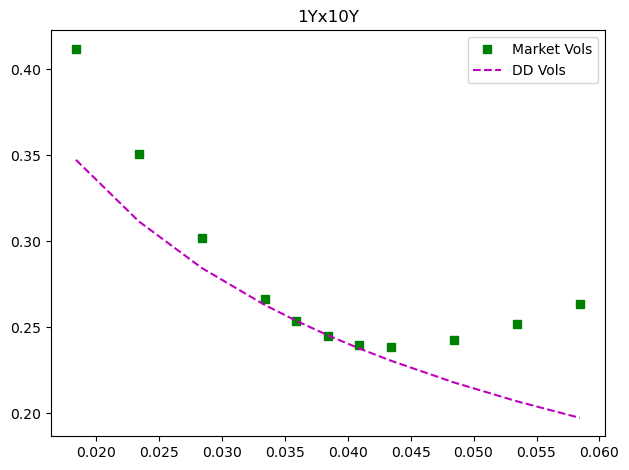

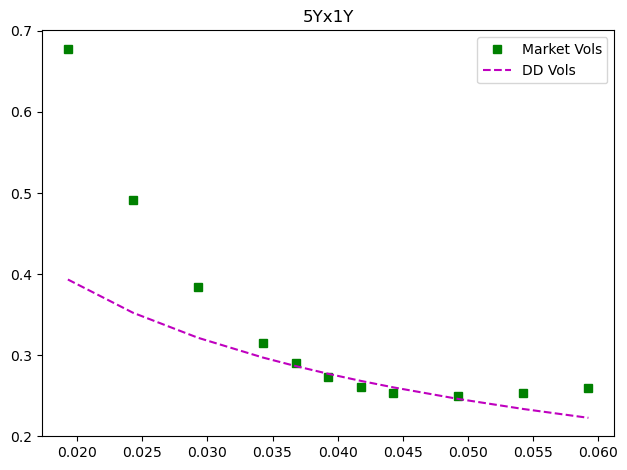

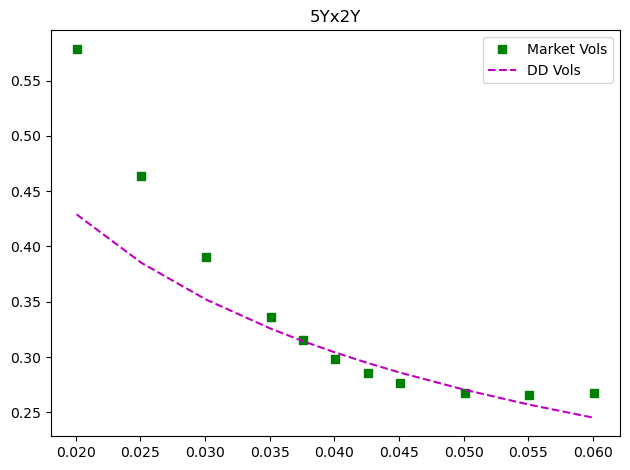

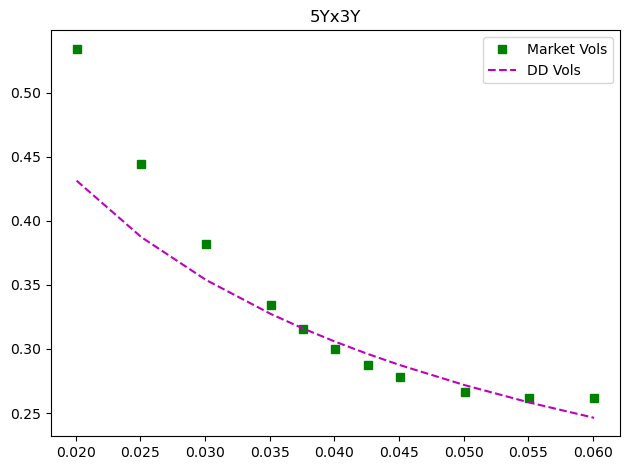

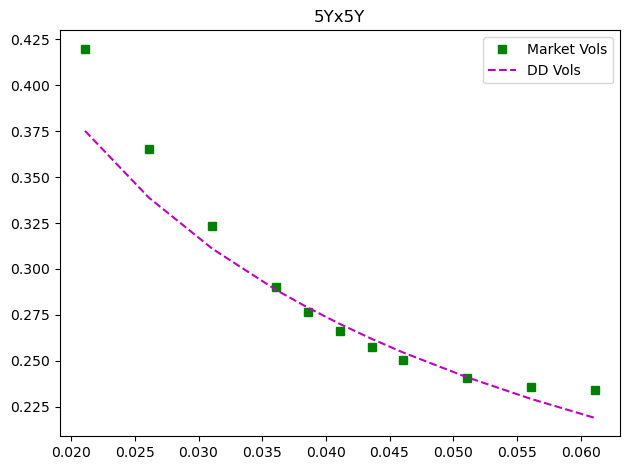

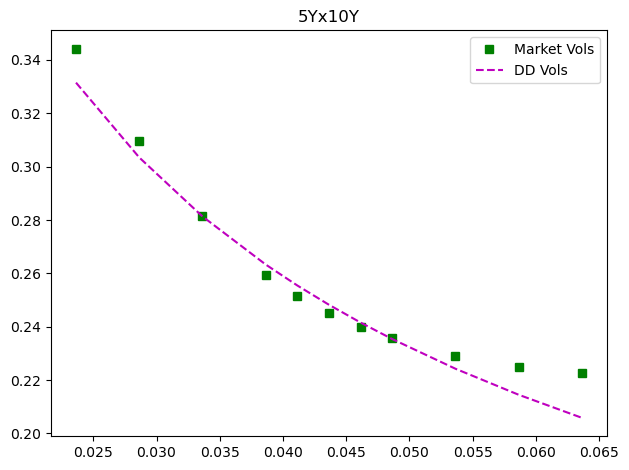

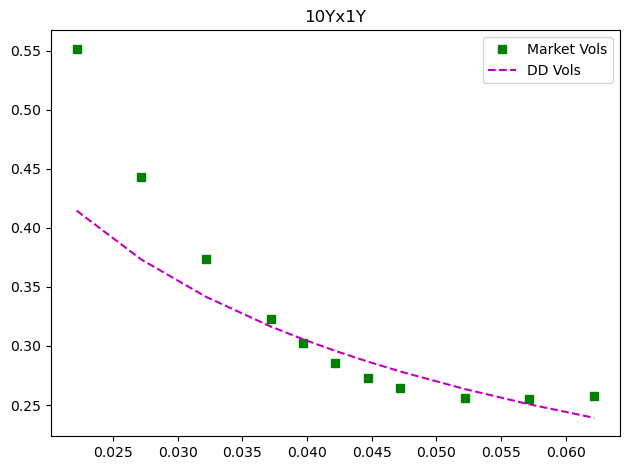

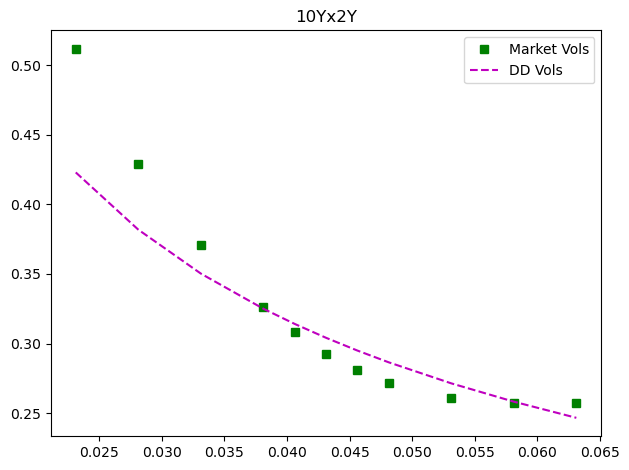

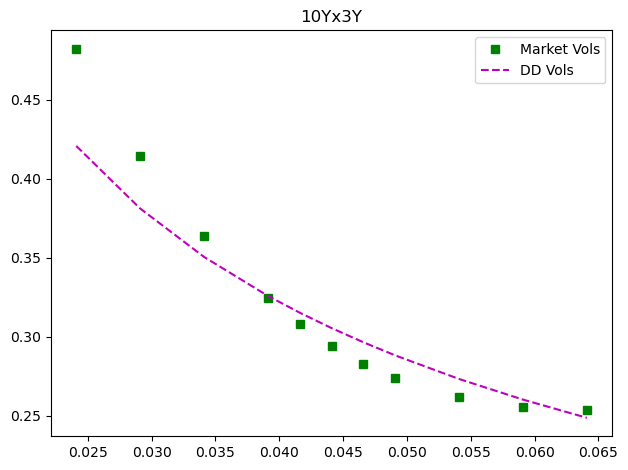

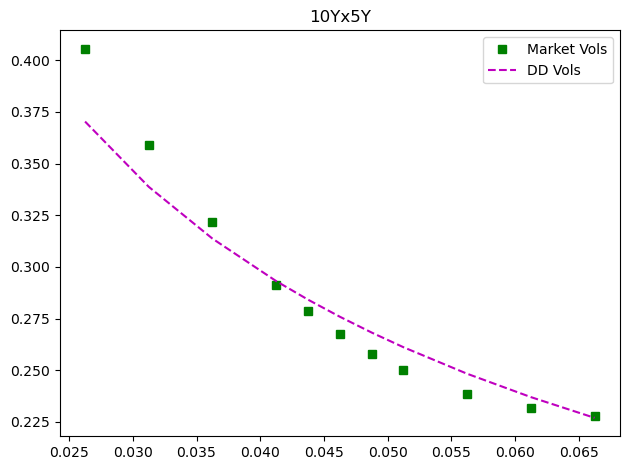

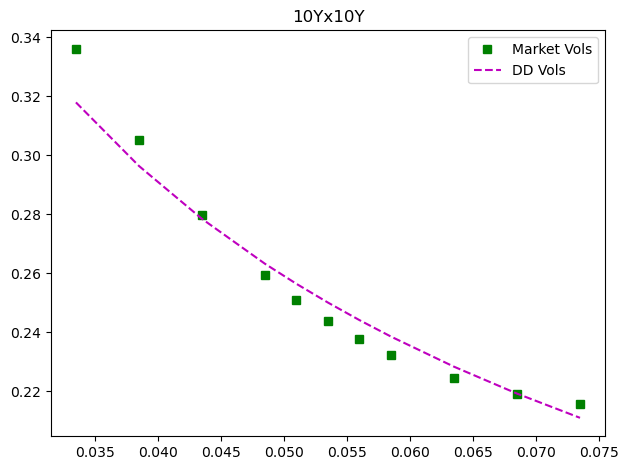

In [17]:
#Plot DD calibration results
for idx, row in displaced_diffusion_results_df.iterrows():
    ddvols = []
    temp_expiry = row["Expiry"]
    temp_tenor = row["Tenor"]
    temp_df = data_df[(data_df["Expiry"] == temp_expiry) & (data_df["Tenor"] == temp_tenor)].copy()
    temp_F = temp_df["parSwap"].iloc[0]
    temp_expiry_T = temp_df["Expiry_no"].iloc[0]
    temp_tenor_T = temp_df["Tenor_no"].iloc[0]
    temp_PVBP = PVBP_calculation(temp_expiry_T, temp_tenor_T)

    for K in temp_df['strike']:
        ddvols.append(ImpVol(temp_F, K, temp_PVBP, temp_expiry_T, row["Sigma"], row["Beta"]))

    plt.figure(tight_layout=True)
    plt.plot(temp_df['strike'], temp_df['impliedVol'], 'gs', label='Market Vols')
    plt.plot(temp_df['strike'], ddvols, 'm--', label='DD Vols')
    plt.title(temp_expiry + "x" + temp_tenor)
    plt.legend()
    plt.show()

# SABR Calibration

In [18]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [19]:
beta = 0.9

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

In [20]:
#SABR calibration
sabr_results = []

for expiry in expiry_list:
    for tenor in tenor_list:
        calibrate_df = data_df[(data_df['Expiry'] == expiry) & (data_df['Tenor'] == tenor)].copy()
        T = calibrate_df['Expiry_no'].iloc[0]
        r = 0
        F = calibrate_df['parSwap'].iloc[0]

        initialGuess = [0.02, 0.2, 0.1]
        res = least_squares(lambda x: sabrcalibration(x,
                                                    calibrate_df['strike'].values,
                                                    calibrate_df['impliedVol'].values,
                                                    F,
                                                    T),
                            initialGuess,
                            bounds=([0,-1,0],[np.inf,1,np.inf]),
        )
        alpha = res.x[0]
        rho = res.x[1]
        nu = res.x[2]

        temp = [expiry, tenor, alpha, rho, nu]
        sabr_results.append(temp)

In [21]:
#Generate SABR calibration results df
sabr_results_df = pd.DataFrame(sabr_results)
sabr_results_df.columns = ["Expiry", "Tenor", "Alpha", "Rho", "Nu"]

In [22]:
#Generate calibrated Alpha parameters table
alpha_df = sabr_results_df[["Expiry","Tenor", "Alpha"]].copy()
alpha_df["Tenor"] = alpha_df["Tenor"].apply(lambda x: int(x.split("Y")[0]))

original_expiry_order = alpha_df["Expiry"].unique()
original_tenor_order = alpha_df["Tenor"].unique()
alpha_df.pivot(index="Expiry", columns="Tenor").reindex(index = original_expiry_order)

Alpha                                        
Tenor         1         2         3         5         10
Expiry                                                  
1Y      0.139068  0.184644  0.196849  0.178052  0.171069
5Y      0.166439  0.198418  0.208395  0.189404  0.170976
10Y     0.176431  0.189789  0.197319  0.183315  0.163441

In [23]:
#Generate calibrated Rho parameters table
rho_df = sabr_results_df[["Expiry","Tenor", "Rho"]].copy()
rho_df["Tenor"] = rho_df["Tenor"].apply(lambda x: int(x.split("Y")[0]))

original_expiry_order = rho_df["Expiry"].unique()
original_tenor_order = rho_df["Tenor"].unique()
rho_df.pivot(index="Expiry", columns="Tenor").reindex(index = original_expiry_order)

Rho                                        
Tenor         1         2         3         5         10
Expiry                                                  
1Y     -0.633235 -0.525119 -0.482842 -0.414419 -0.264552
5Y     -0.584653 -0.542050 -0.542069 -0.501324 -0.373639
10Y    -0.541753 -0.526903 -0.522066 -0.497675 -0.410726

In [24]:
#Generate calibrated Nu parameters table
nu_df = sabr_results_df[["Expiry","Tenor", "Nu"]].copy()
nu_df["Tenor"] = nu_df["Tenor"].apply(lambda x: int(x.split("Y")[0]))

original_expiry_order = nu_df["Expiry"].unique()
original_tenor_order = nu_df["Tenor"].unique()
nu_df.pivot(index="Expiry", columns="Tenor").reindex(index = original_expiry_order)

Nu                                        
Tenor         1         2         3         5         10
Expiry                                                  
1Y      2.049522  1.677442  1.438154  1.064889  0.778023
5Y      1.338832  1.058597  0.934577  0.676572  0.532442
10Y     1.002606  0.909290  0.847046  0.706222  0.601842

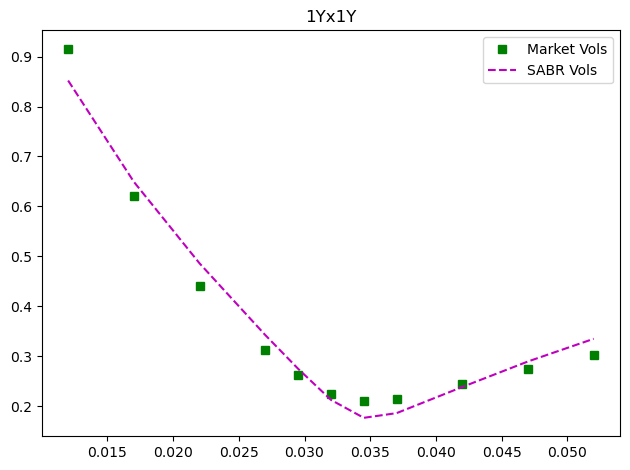

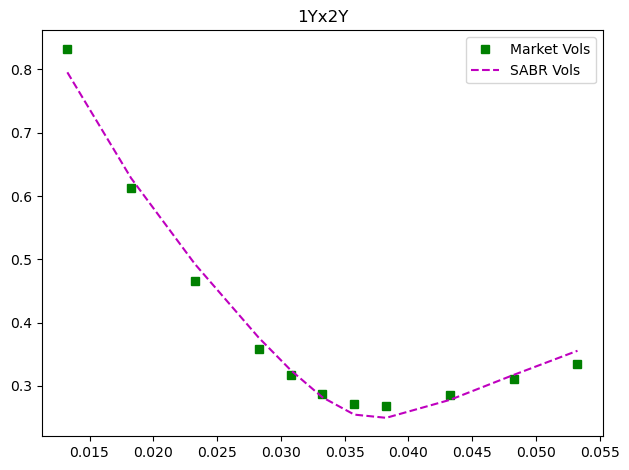

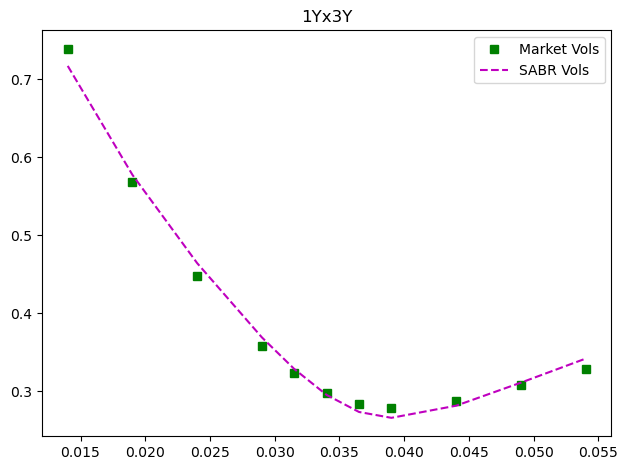

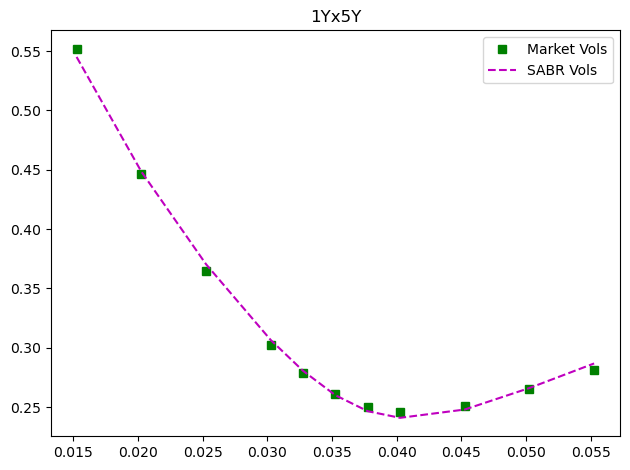

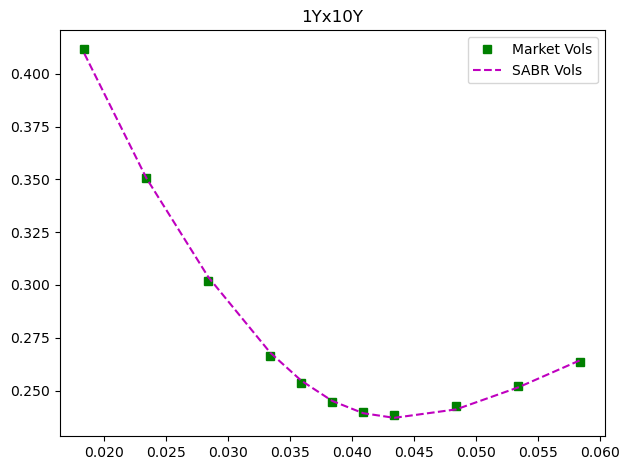

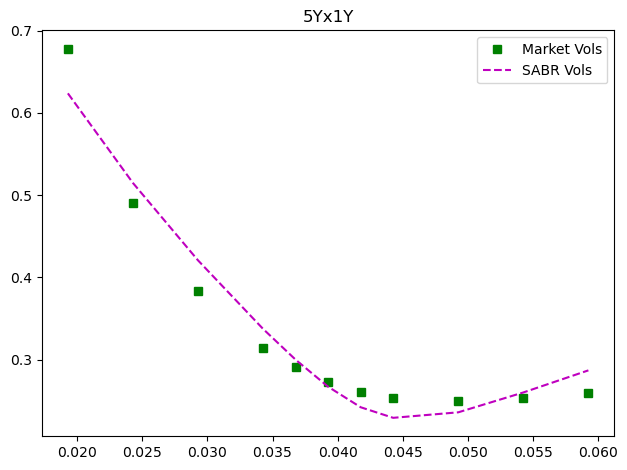

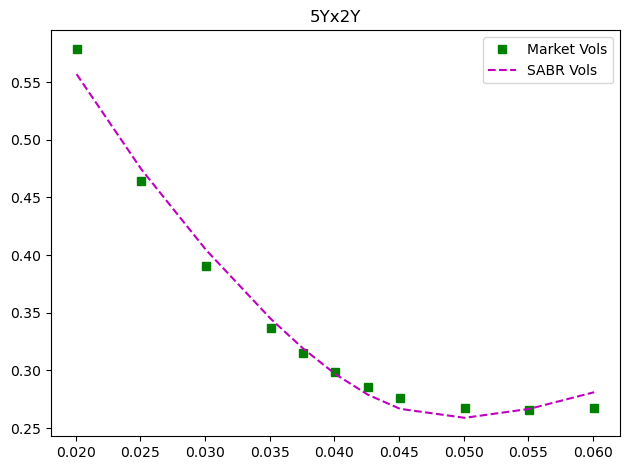

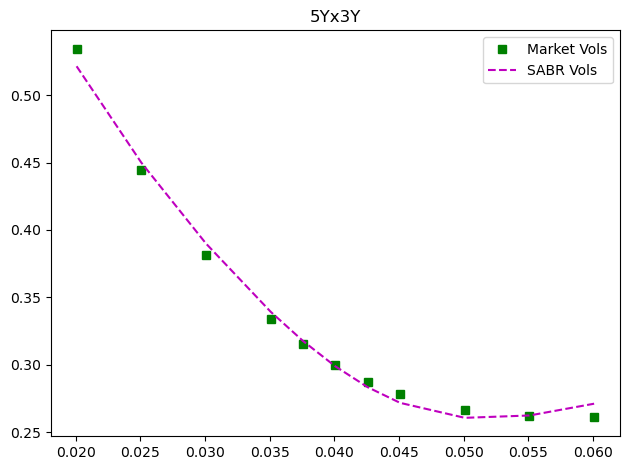

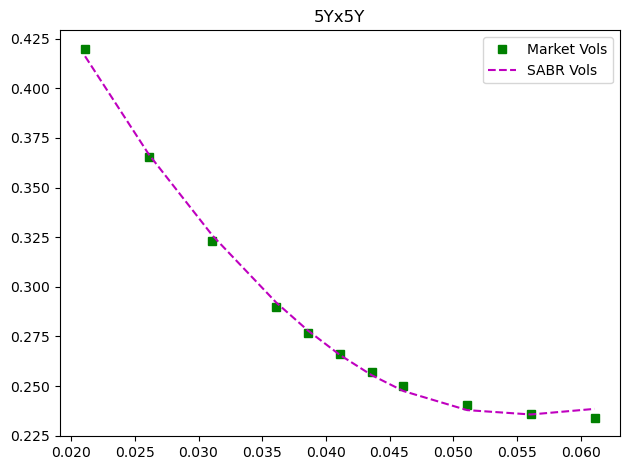

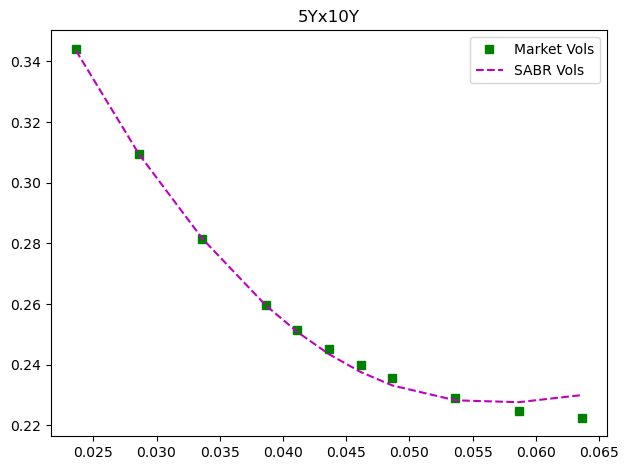

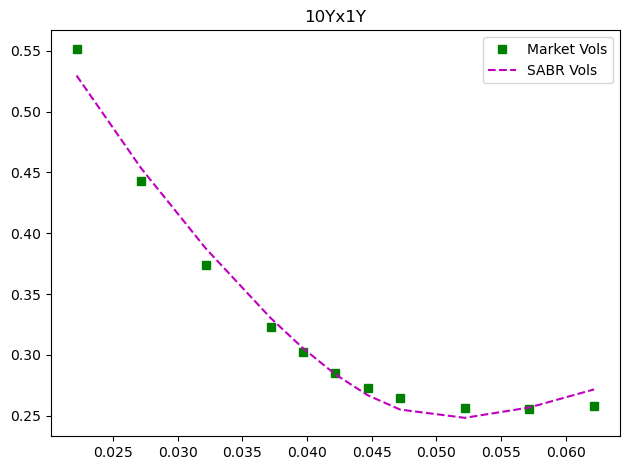

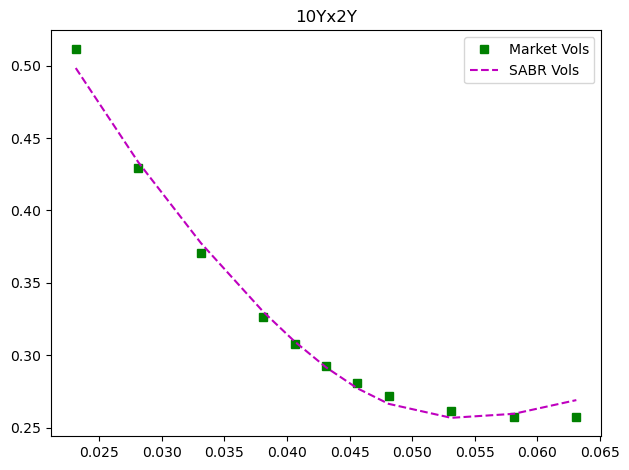

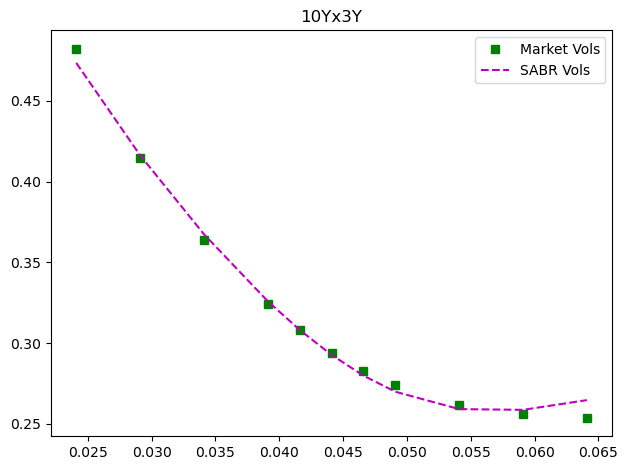

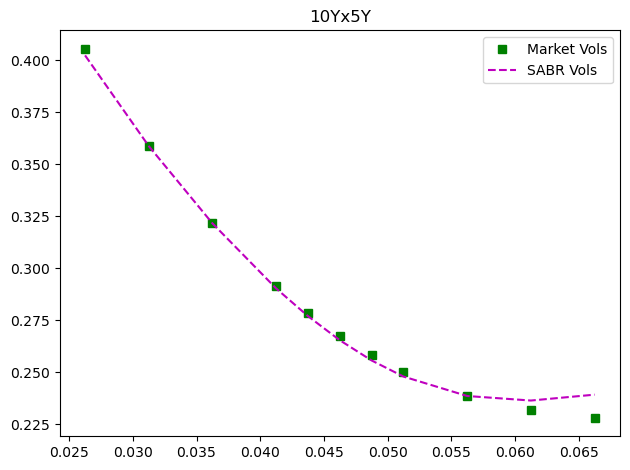

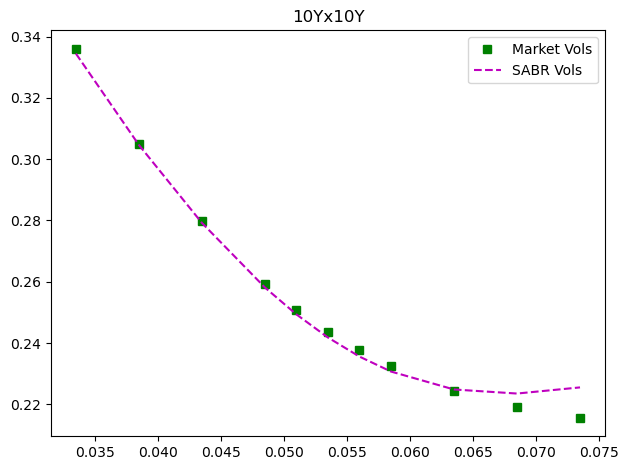

In [25]:
#Plot SABR calibration results
for idx, row in sabr_results_df.iterrows():
    sabrvols = []
    temp_expiry = row["Expiry"]
    temp_tenor = row["Tenor"]
    temp_df = data_df[(data_df["Expiry"] == temp_expiry) & (data_df["Tenor"] == temp_tenor)].copy()
    temp_F = temp_df["parSwap"].iloc[0]
    temp_T = temp_df["Expiry_no"].iloc[0]

    for K in temp_df['strike']:
        sabrvols.append(SABR(temp_F, K, temp_T, row["Alpha"], 0.9, row["Rho"], row["Nu"]))

    plt.figure(tight_layout=True)
    plt.plot(temp_df['strike'], temp_df['impliedVol'], 'gs', label='Market Vols')
    plt.plot(temp_df['strike'], sabrvols, 'm--', label='SABR Vols')
    plt.title(temp_expiry + "x" + temp_tenor)
    plt.legend()
    plt.show()

# Pricing Swaptions
1. payer 2y × 10y K = 1%, 2%, 3%, 4%, 5%, 6%, 7%, 8%
2. receiver 8y × 10y K = 1%, 2%, 3%, 4%, 5%, 6%,7%,8%

$\text{Payer 2y x 10y par swap} = \frac{\sum_{i=2.5}^{12} D_o(0,t_i)*L(t_{i-0.5}, t_i)}{0.5  \sum_{i=2.5}^{12} D_o(0,t_i)} $

$\text{Payer 8y x 10y par swap} = \frac{\sum_{i=8.5}^{18} D_o(0,t_i)*L(t_{i-0.5}, t_i)}{0.5  \sum_{i=8.5}^{18} D_o(0,t_i)} $

In [37]:
#Calculate Libor forward rate
def Libor_forward(D1,D2,delta = 0.5):
    L1 = (D1/D2-1)/delta
    return L1

#Interpolate Libor discount factor
def LiborDifInterp(tenor):
    xp = list(discount_factors_df['Tenor'])
    yp = list(discount_factors_df['LIBOR Discount Factor'])
    return np.interp(tenor, xp, yp)

#Calculate float leg of swap
def floatLeg(expiry,tenor,delta=0.5):
    m = int(tenor/delta)
    summa = 0
    for i in range(1,m+1):
        loc = expiry + i*delta
        summa += OISDifInterp(loc)*Libor_forward(LiborDifInterp(loc-delta),LiborDifInterp(loc),delta)
    return summa*delta

#Par Swap Rate based on Tenor and Expiry
def Swaption(expiry, tenor):
    return floatLeg(expiry,tenor)/PVBP_calculation(expiry,tenor)

In [45]:
#Interpolate calibrated params
def ParamInterp(expiry, tenor, df, param):
    temp_df = df.copy()
    temp_df["Expiry"] = temp_df["Expiry"].apply(lambda x: int(x.split("Y")[0]))
    temp_df["Tenor"] = temp_df["Tenor"].apply(lambda x: int(x.split("Y")[0]))
    temp_df = temp_df[temp_df["Tenor"] == tenor].copy()
    temp_df = temp_df.sort_values(by=["Expiry"]).reset_index(drop = True)

    xp = list(temp_df['Expiry'])
    yp = list(temp_df[param])
    return np.interp(expiry, xp, yp)

In [91]:
K_list = [i/100 for i in range(1,9)]
swaptions_pricing =pd.DataFrame(index=['Pay 2yx10y DD','Pay 2yx10y SABR','Rec 8yx10y DD','Rec 8yx10y SABR'],columns=K_list)

In [103]:
# payer 2y x 10y
alpha_Pay = ParamInterp(expiry = 2,tenor = 10, df = sabr_results_df, param = "Alpha")
rho_Pay = ParamInterp(expiry = 2,tenor = 10, df = sabr_results_df, param = "Rho")
nu_Pay = ParamInterp(expiry = 2,tenor = 10, df = sabr_results_df, param = "Nu")
beta_Pay = ParamInterp(expiry = 2,tenor = 10, df = displaced_diffusion_results_df, param = "Beta")
sigma_Pay = ParamInterp(expiry = 2,tenor = 10, df = displaced_diffusion_results_df, param = "Sigma")
F_Pay = Swaption(2,10)


In [104]:
for k in K_list:
    PVBP_2_10 = PVBP_calculation(2, 10)
    PricePayDD   = DisplacedDiffusionCall(F_Pay,k, PVBP_2_10, sigma_Pay, 2, beta_Pay) 
    PricePaySABR = Black76Call(F_Pay,k, PVBP_2_10, SABR(F_Pay, k, 2, alpha_Pay, 0.9, rho_Pay, nu_Pay), 2)
    swaptions_pricing.loc['Pay 2yx10y DD',k]=PricePayDD
    swaptions_pricing.loc['Pay 2yx10y SABR',k]=PricePaySABR

In [108]:
# receiver 8y x 10y
alpha_Rec = ParamInterp(expiry = 8,tenor = 10, df = sabr_results_df, param = "Alpha")
rho_Rec = ParamInterp(expiry = 8,tenor = 10, df = sabr_results_df, param = "Rho")
nu_Rec = ParamInterp(expiry = 8,tenor = 10, df = sabr_results_df, param = "Nu")
beta_Rec = ParamInterp(expiry = 8,tenor = 10, df = displaced_diffusion_results_df, param = "Beta")
sigma_Rec = ParamInterp(expiry = 8,tenor = 10, df = displaced_diffusion_results_df, param = "Sigma")
F_Rec = Swaption(8,10)

In [109]:
for k in K_list:
    PVBP_8_10 = PVBP_calculation(8, 10)
    PriceRecDD   = DisplacedDiffusionPut(F_Rec, k, PVBP_8_10, sigma_Rec, 8, beta_Rec) 
    PriceRecSABR = Black76Put(F_Rec, k, PVBP_8_10, SABR(F_Rec, k, 8, alpha_Rec, 0.9, rho_Rec, nu_Rec), 8)
    swaptions_pricing.loc['Rec 8yx10y DD',k]=PriceRecDD
    swaptions_pricing.loc['Rec 8yx10y SABR',k]=PriceRecSABR

In [110]:
swaptions_pricing

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08
Pay 2yx10y DD,0.288145,0.194942,0.112333,0.051344,0.017359,0.0041,0.000649,0.000067
Pay 2yx10y SABR,0.289627,0.198272,0.114981,0.051903,0.021474,0.01102,0.006925,0.004929
Rec 8yx10y DD,0.018997,0.033915,0.056658,0.088985,0.13205,0.18613,0.250571,0.323959
Rec 8yx10y SABR,0.020639,0.039369,0.060833,0.08858,0.128581,0.186874,0.261364,0.344863
